## Importing things 

In [4]:
import sys
sys.path.append('../misc')

from MoviaBusDataset import MoviaBusDataset
from BaseNetwork import BaseNetwork
import numpy as np
from FNN import FNN
from Seq2Seq import Seq2Seq
import pandas as pd


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [2]:
previous_timesteps = 6
prediction_steps = 6
batch_size = 25

train = MoviaBusDataset('../data/train', interpolation=True, 
                        prev_timesteps=previous_timesteps, 
                        max_future_time_steps=prediction_steps, 
                        timeofday = True)
train2 = MoviaBusDataset('../data/train', interpolation=True, 
                        prev_timesteps=previous_timesteps, 
                        max_future_time_steps=prediction_steps, 
                        )

validation = MoviaBusDataset('../data/validation', interpolation=True, 
                       prev_timesteps=previous_timesteps, 
                       max_future_time_steps=prediction_steps, 
                       timeofday = True)
validation2 = MoviaBusDataset('../data/validation', interpolation=True, 
                       prev_timesteps=previous_timesteps, 
                       max_future_time_steps=prediction_steps)


test = MoviaBusDataset('../data/test', interpolation=True, 
                       prev_timesteps=previous_timesteps, 
                       max_future_time_steps=prediction_steps, 
                       timeofday = True)
test2 = MoviaBusDataset('../data/test', interpolation=True, 
                       prev_timesteps=previous_timesteps, 
                       max_future_time_steps=prediction_steps)


AttributeError: 'MoviaBusDataset' object has no attribute 'pivot'

In [5]:
train_all = pd.concat(train.dataframes,sort=False).unstack().reset_index().rename(columns={0:"Speed"})
train_road_mean = train_all.pivot(index='Time', columns='LinkRef',values='Speed').groupby(['TimeOfDay']).mean()

train.remove_trend()
validation.remove_trend(train._historical_average)
test.remove_trend(train._historical_average)

train2.remove_trend()
validation2.remove_trend(train2._historical_average)
test2.remove_trend(train2._historical_average)

train2.normalize(individual_roads=False)
validation2.normalize(train2.mean, train2.std)
test2.normalize(train2.mean, train2.std)

## FNN

In [35]:
net_FNN = FNN(num_hidden=20)
net_FNN.load('FNN.pt')

validation_scores=[net_FNN.get_MAE_score(validation,timestep=i) for i in range(1,prediction_steps+1)]
print('Validation score:\n',validation_scores)
print('\nMean validation score for all timesteps:\n',sum(validation_scores)/len(validation_scores))

test_scores=[net_FNN.get_MAE_score(test,timestep=i) for i in range(1,prediction_steps+1)]
print('\nTest score:\n',test_scores)
print('\nMean test score for all timesteps:\n',sum(test_scores)/len(test_scores))

Validation score:
 [1.4688012599945068, 1.5080206394195557, 1.5228253602981567, 1.53152596950531, 1.5421222448349, 1.5539180040359497]

Mean validation score for all timesteps:
 1.5212022463480632

Test score:
 [1.464704990386963, 1.5006828308105469, 1.5135881900787354, 1.5224415063858032, 1.5305694341659546, 1.5355161428451538]

Mean test score for all timesteps:
 1.5112505157788594


In [36]:
net_FNN.visualize_road(test, timesteps=1, road=17)

## Seq2Seq

In [37]:
net_s2s = Seq2Seq()
net_s2s._BaseNetwork__target_to_net = True
net_s2s.load('Sequence2Sequence.pt')

validation_scores=[net_s2s.get_MAE_score(validation2,timestep=i) for i in range(1,prediction_steps+1)]
print('Validation score:\n',validation_scores)
print('\nMean validation score for all timesteps:\n',sum(validation_scores)/len(validation_scores))

test_scores=[net_s2s.get_MAE_score(test2,timestep=i) for i in range(1,prediction_steps+1)]
print('\nTest score:\n',test_scores)
print('\nMean test score for all timesteps:\n',sum(test_scores)/len(test_scores))

Validation score:
 [1.5216959714889526, 1.5257223844528198, 1.5299543142318726, 1.534583330154419, 1.5416487455368042, 1.5448428392410278]

Mean validation score for all timesteps:
 1.5330745975176494

Test score:
 [1.5241366624832153, 1.5242396593093872, 1.5267146825790405, 1.5291073322296143, 1.5355256795883179, 1.540012240409851]

Mean test score for all timesteps:
 1.529956042766571


# Visualize all predictions 

In [98]:
road_nr = 59
time_steps_nr = 1
time,out_s2s,tar = net_s2s.visualize_road(test2, timesteps=time_steps_nr, road=road_nr,return_values=True)
_,out_fnn,_ = net_FNN.visualize_road(test, timesteps=time_steps_nr, road=road_nr,return_values=True)
with np.load('../dcrnn.npz') as data:
    # also contains groundtruth
    out_dcrnn = data['predictions'][:,:,road_nr]
    
net_dcrnn = out_dcrnn[time_steps_nr-1,0:90]+train_road_mean.values[6:-6,16]

<IPython.core.display.Javascript object>


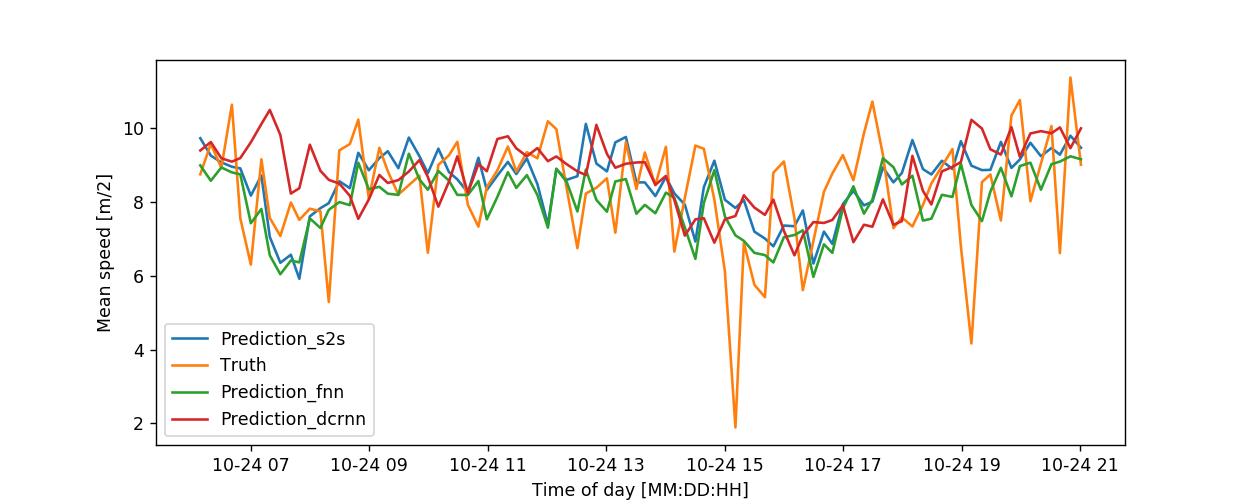

In [99]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.plot(time[0:90],out_s2s[0:90], label='Prediction_s2s')
plt.plot(time[0:90],tar[0:90], label='Truth')
plt.plot(time[0:90],out_fnn[0:90], label='Prediction_fnn')
plt.plot(time[0:90],net_dcrnn,label='Prediction_dcrnn')
plt.legend()
plt.xlabel('Time of day [MM:DD:HH]')
plt.ylabel('Mean speed [m/2]')
plt.rcParams["figure.figsize"] = [10,4]
plt.show()

## DCRNN 

<IPython.core.display.Javascript object>


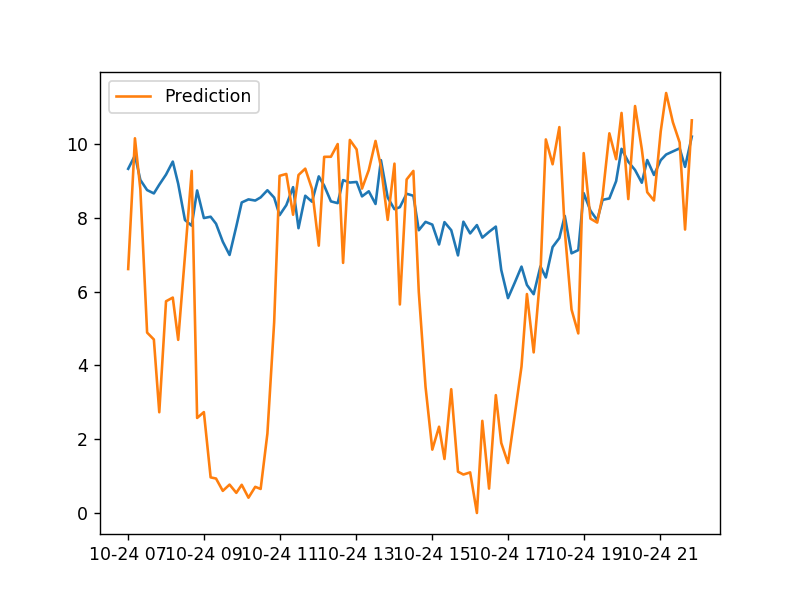

In [43]:

len(time)
102*3-8*3
train_road_mean
%matplotlib notebook
plt.plot(time[0:90],train_road_mean.values[6:-6,16])
plt.plot(time[0:90],tar[0:90], label='Prediction')
plt.legend()
plt.show()

## Plotting

<IPython.core.display.Javascript object>


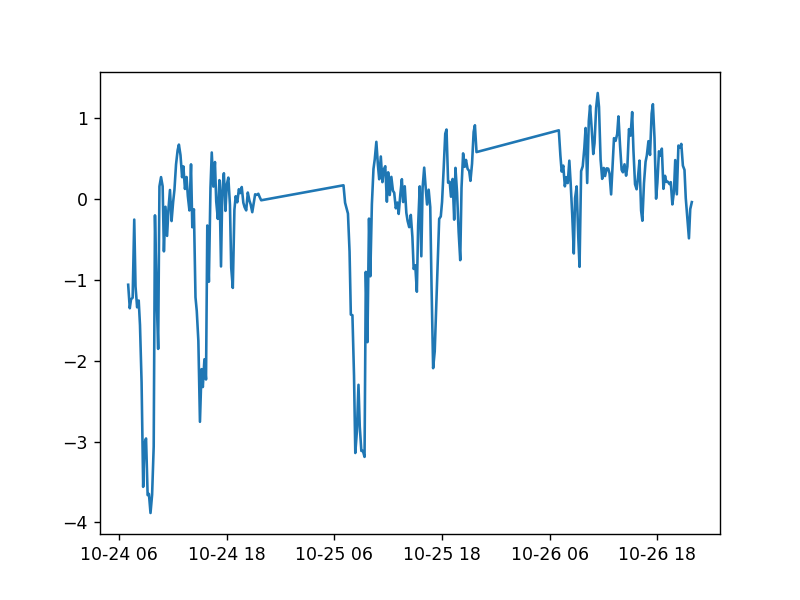

In [44]:
%matplotlib notebook
plt.plot(time,out_dcrnn[1,6:-1])

In [ ]:
len(time)

In [48]:
len(out_dcrnn[1,6:96]+train_road_mean.values[6:-6,16])

90

<IPython.core.display.Javascript object>


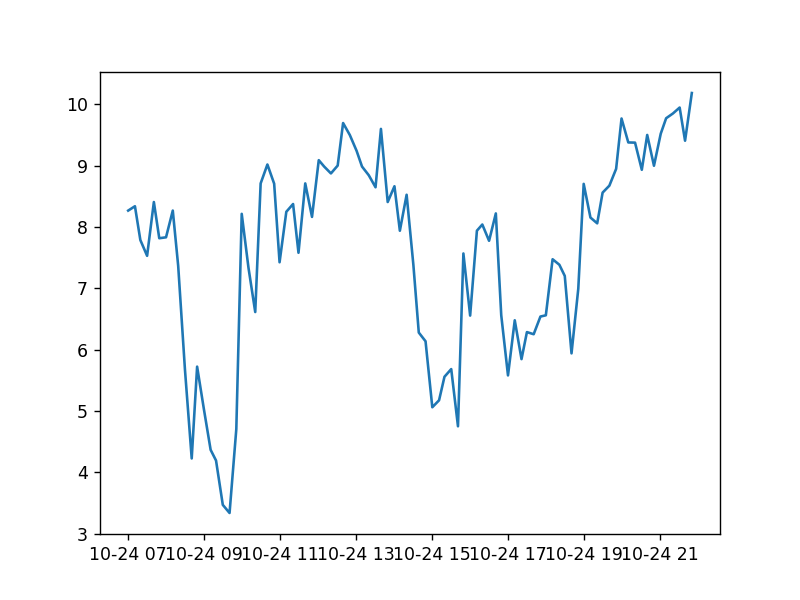

In [50]:
%matplotlib notebook
plt.plot(time[0:90],out_dcrnn[1,6:96]+train_road_mean.values[6:-6,16])